In [361]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az
import seaborn as sns

import pandas as pd

In [362]:
data = pd.read_csv("prev_test_data.csv")
data = data.set_index("index")
data.head()

,result
index,
0,False
1,False
2,False
3,False
4,False


In [363]:
data["result"] = data.apply(lambda row: int(row["result"]), axis = 1)
data.head()

,result
index,
0,0
1,0
2,0
3,0
4,0


In [364]:
sens = 0.986
spec = 0.92

N = data.size

In [365]:
#p(0|prev) = p(0|neg)*p(neg|prev) + p(0|pos)*p(pos|prev) = spec*(1-prev) + (1-sens)*prev
#p(1|prev) = p(1|neg)*p(neg|prev) + p(1|pos)*p(pos|prev) = (1-spec)*(1-prev) + sens*prev = 1 - p(0|prev)

def likelihood(df, prev):
    prob = (sens*prev + (1-spec)*(1-prev))**(data["result"].values) * (spec*(1-prev) + (1-sens)*prev)**(1-data["result"].values)
    return np.prod(prob, axis = 1)

#def log_likelihood(df, prev):
#    log_prob = np.log(sens*prev + (1-spec)*(1-prev))*(data["result"].values) + np.log(spec*(1-prev) + (1-sens)*prev)*(1-data["result"].values)
#    return log_prob.sum()   

In [366]:
#print(likelihood(data, np.array([[0.02]])))
#print(log_likelihood(data, 0.02))
#print(np.log(likelihood(data, 0.02)))

In [367]:
#def log_prior(prev):
#    return pm.Beta.dist(1, 10).logp(prev).eval()
def prior(prev):
    return np.exp(pm.Beta.dist(1, 10).logp(prev).eval())

In [368]:
prevs = np.linspace(0, 1, 1000).reshape(-1, 1)
priors = prior(prevs)[:, 0]

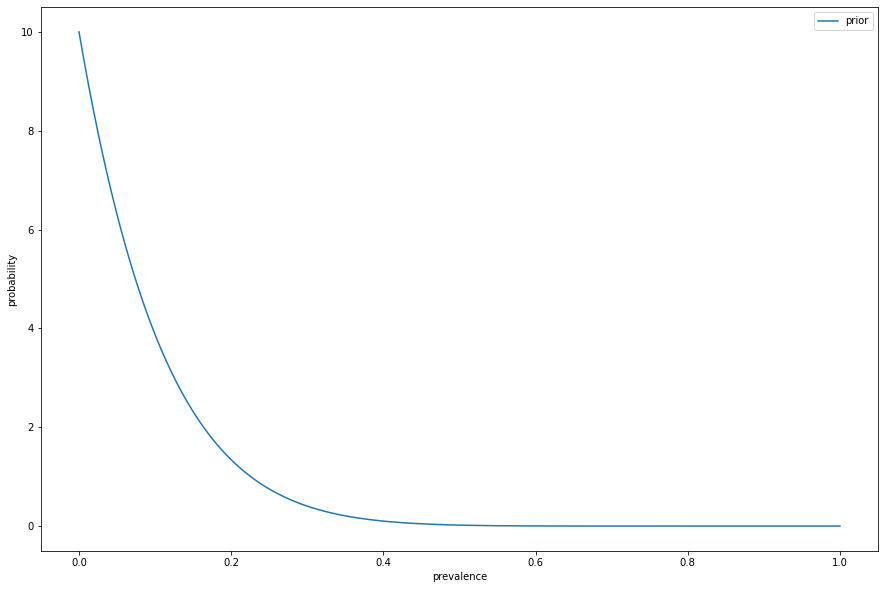

In [369]:
fig = plt.figure(figsize = [15, 10])
plt.plot(prevs, priors, label = "prior")
plt.xlabel("prevalence")
plt.ylabel("probability")
plt.legend()

In [370]:
#evidence
def evidence(df):
    prevs = np.linspace(0, 1, 1000).reshape(-1, 1)
    step = 1/1000
    
    lik = likelihood(data, prevs)
    pri = prior(prevs)[:, 0]
    return (lik*pri).sum() * step

ev = evidence(data)

In [371]:
def posterior(prev, data): #prev == sloupcový vektor
    return (likelihood(data, prev) * prior(prev)[:, 0])/ev

In [372]:
prevs = np.linspace(0, 1, 1000).reshape(-1, 1)
post = posterior(prevs, data)

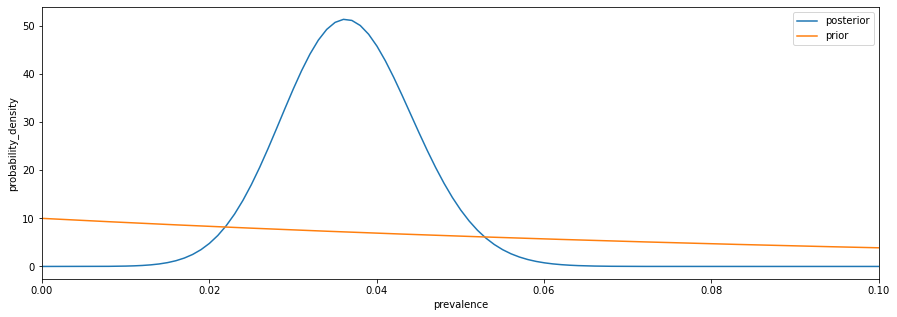

In [376]:
fig = plt.figure(figsize = [15, 5])
plt.plot(prevs, post, label = "posterior")
plt.plot(prevs, priors, label = "prior")
plt.xlabel("prevalence")
plt.ylabel("probability_density")
plt.xlim(0, 0.1)
plt.legend()

In [377]:
mean_prev = (prevs[:, 0]*post).mean()
mean_prev

0.03669549190346841

In [378]:
var_prev = (post * (prevs[:, 0] - mean_prev)**2).mean()
sd_prev = np.sqrt(var_prev)
sd_prev

0.007776231997789413

In [ ]:
E((X - EX)**2)

In [ ]:
#Pymc3 version

In [307]:
with pm.Model() as model:
    prev = pm.Beta("prev", 1, 10)
    likelihood = pm.Bernoulli("likelihood", p = (sens*prev + (1-spec)*(1-prev)), observed = data["result"].values)

In [339]:
with model:
    trace = pm.sample()

/Users/hynekjakes/opt/anaconda3/lib/python3.8/site-packages/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prev]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 32 seconds.


/Users/hynekjakes/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'prev'}>,
        <AxesSubplot:title={'center':'prev'}>]], dtype=object)

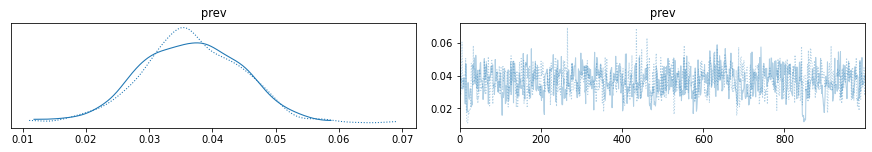

In [340]:
az.plot_trace(trace)

In [353]:
az.summary(trace)

/Users/hynekjakes/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
prev,0.037,0.008,0.022,0.051,0.0,0.0,610.0,565.0,1.0


/Users/hynekjakes/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

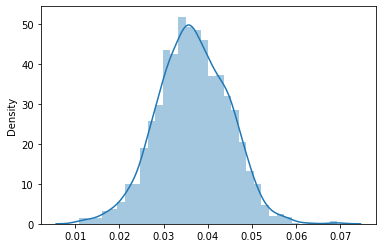

In [351]:
sns.distplot(trace["prev"])